In [79]:
import polars.selectors as cs
import numpy as np

import polars as pl
import matplotlib as mpl
import matplotlib_inline.backend_inline

import matplotlib.pyplot as plt

LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.frameon'] = False


In [80]:
index_cols = {
    1: ['l_returnflag', 'l_linestatus'],
    3: ['l_orderkey','o_orderdate','o_shippriority'],
    4: ['o_orderpriority'],
    5: ['n_name'],
    6: [],
    7: ['supp_nation', 'cust_nation', 'l_year'], 
    8: ['o_year'],
    9: ['nation', 'o_year'],
    10: ['c_custkey', 'c_name', 'c_acctbal', 'c_phone', 'n_name', 'c_address', 'c_comment'],
    12: ['l_shipmode'],
    13: ['c_count'],
    14: [],
    
    17: [],
    19: [],
    20: [],
    21: ['s_name'],
    22: ['cntrycode']
}
scale_required = set([1,4, 5, 6, 7, 9, 12, 13, 17, 19, 21, 22])
# not 8, 14
# skip 3, skip 20
queries_to_run = [1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 17, 19, 21, 22]



In [81]:
q4_dp = {'1-URGENT': [1.5194296720479534,
  1.094468236658718,
  0.7677982123826405,
  0.5233617997164477,
  0.3740499402311892,
  0.24066195120478603,
  0.13190727953998826,
  0.033733693081375485,
  0.03181246362725816,
  0.0344590906150468],
 '2-HIGH': [1.4984674508752356,
  1.0543596964080473,
  0.7685002937899762,
  0.5333070177194006,
  0.34200341751368196,
  0.23019289798861586,
  0.13277080103935632,
  0.033749758599309045,
  0.032291904751306416,
  0.03538837280466953],
 '3-MEDIUM': [1.538285365138232,
  1.0933034034353346,
  0.7681120431906947,
  0.5309749899030749,
  0.35899898587737816,
  0.24141832312979533,
  0.13643669208672518,
  0.03545123028900187,
  0.03509203989165155,
  0.03475905594119786],
 '4-NOT SPECIFIED': [1.5608087226160874,
  1.1484897350449714,
  0.7322571696923756,
  0.5325028527706469,
  0.3440538720575913,
  0.23102782622316567,
  0.1282993532906053,
  0.031585530688739774,
  0.03278226378285262,
  0.033871386168238975],
 '5-LOW': [1.552337699710857,
  1.1303742489362625,
  0.7976920170611799,
  0.5531959077889949,
  0.36890026787175034,
  0.24465525650449557,
  0.1328028630477505,
  0.03565367187655484,
  0.03175774873730645,
  0.03501684846779618]}

In [82]:
def graph_query1(full_df):
    print("Q1")
    q1_dict = {'pct_diff_avg_qty': "Average Quantity",
     'pct_diff_avg_price': "Average Price",
     'pct_diff_sum_disc_price': "Sum of Discounted Price",
     'pct_diff_sum_qty': "Sum of Quantity of Lineitems",
     'pct_diff_sum_base_price': "Sum of Base Price",
     'pct_diff_avg_disc': "Average Discount",
     'pct_diff_count_order': "Count of Lineitems",
     'pct_diff_sum_charge': "Sum of Total Price "}
    # Create 4x2 subplot grid
    fig, axes = plt.subplots(4, 2, figsize=(15,8), sharex=True)

    pct_diff_cols = [col for col in merged_df.columns if col.startswith('pct_diff')]
    returnflag = full_df['l_returnflag'].unique().sort()
    linestatus = full_df['l_linestatus'].unique().sort()

    # First pass: collect all y-data for each row to determine shared y-limits
    row_y_data = {row: [] for row in range(4)}

    for i, col in enumerate(pct_diff_cols):
        row = i // 2

        for flag in returnflag:
            for status in linestatus:
                group_data = (full_df
                             .filter(pl.col('l_linestatus') == status)
                             .filter(pl.col('l_returnflag') == flag)
                             .sort('mi'))
                y = group_data[col]
                if len(y.to_list()) > 0:
                    row_y_data[row].extend(y.to_list())

    # Calculate y-limits for each row
    row_y_limits = {}
    for row in range(4):
        if row_y_data[row]:
            y_min = min(row_y_data[row])
            y_max = max(row_y_data[row])
            # Add some padding
            y_range = y_max - y_min
            padding = y_range * 0.05
            row_y_limits[row] = (y_min - padding, y_max + padding)
        else:
            row_y_limits[row] = (0, 1)  # default range
    global_handles = []
    global_labels = []
    # Second pass: create the plots
    for i, col in enumerate(pct_diff_cols):
        print(col)
        row = i // 2
        col_idx = i % 2
        ax = axes[row, col_idx]

        for flag in returnflag:
            for status in linestatus:
                group_data = (full_df
                             .filter(pl.col('l_linestatus') == status)
                             .filter(pl.col('l_returnflag') == flag)
                             .sort('mi'))
                xs = [np.log2(x) for x in group_data['mi']]
                y = group_data[col]
#                 print(flag, status, y.to_list())
                if len(y.to_list()) > 0:
                    print(flag, status, y.to_list())
                    line = ax.plot(xs, y.to_list(),linestyle='dotted',
                        label=f'Return Flag: {flag}, Status: {status}', 
                        linewidth=3)[0]
                    if row == 0 and col_idx==0:
                        print(flag, status)
                        global_handles.append(line)
                        global_labels.append(line.get_label())
#         assert(False)

        # Set shared y-limits for this row
        ax.set_ylim(row_y_limits[row])
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        # X-axis label for bottom row only
        if row == 3:  # bottom row
            ax.set_xlabel('Mutual Information (log scale)', fontsize=15)

        # Y-axis label only for left column
        if col_idx == 0:  # left column
            ax.set_ylabel('Relative\nError (%)', fontsize=15)
        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

        ax.set_title(f'Approximating {q1_dict[col]}', fontsize=20)
#         ax.legend(fontsize=14)
        ax.grid(True, alpha=0.3)

    fig.legend(
        handles=global_handles,
        labels=global_labels,
        loc='lower center',
        ncol=4,  # tweak columns as you like
        fontsize=16,
        frameon=False
    )
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.12)

    plt.savefig('../figs/q1_results.png')

In [83]:
def graph_query14(full_df):
    print("Q14!")
    fig, ax = plt.subplots(figsize=(7.5, 2.5))

    xs = [np.log2(x) for x in full_df['mi']]
    y = full_df['pct_diff_promo_revenue']
    print(y.to_list())
    ax.plot(xs, y.to_list(), linestyle='dotted', linewidth=3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
    ax.set_ylabel(f'Relative \n Error (%)', fontsize=15)
    ax.set_title(f'Approximating Promo Revenue Percentage', fontsize=20)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../figs/q14_results.png')

In [84]:
def graph_query12(full_df):
    print("Q12")
    fig, axes = plt.subplots(2, 1, figsize=(7.5,5), sharex=True)
    for ind, key in enumerate(['pct_diff_high_line_count', 'pct_diff_low_line_count']):
        names = ["High", "Low"]
        ax = axes[ind]

        priorities = full_df['l_shipmode'].unique().sort()

        for priority in priorities:
            group_data = full_df.filter(pl.col('l_shipmode') == priority).sort('mi')
            xs = [np.log2(x) for x in group_data['mi']]
            y = group_data[f'pct_diff_{names[ind].lower()}_line_count']
            ax.plot(xs, y.to_list(),linestyle='dotted', linewidth=3,
                label=f'Ship Mode: {priority}'
            )
            print('priority')
            print(y.to_list())

            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)


        ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
        ax.set_ylabel(f'Relative \n Error (%)', fontsize=15)
        ax.set_title(f'Approximating {names[ind]} Line Count', fontsize=20)
        ax.legend(fontsize=16)
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('../figs/q12_results.png')

In [85]:
def graph_query(full_df, query_ind):
    if query_ind == 1:
        graph_query1(full_df)
    if query_ind == 14:
        graph_query14(full_df)
    if query_ind == 4:
        graph_query4(full_df)
    if query_ind == 12:
        graph_query12(full_df)

In [86]:
def graph_query4(full_df):
    print("Q4!")
    fig, axes = plt.subplots(2, 1, figsize=(7.5,5), sharex=True)
    priorities = full_df['o_orderpriority'].unique().sort()
    labels = ["PAC", "DP"]
    for i in range(len(labels)):
        ax = axes[i]
        xs = [np.log2(x) for x in full_df['mi'].unique().sort().to_list()]
        if i == 0:
            print("PAC")
            for priority in priorities:
                group_data = full_df.filter(pl.col('o_orderpriority') == priority).sort('mi')
                
                y = group_data['pct_diff_order_count']
                ax.plot(xs, y.to_list(), linestyle='dotted',
                    label=f'Priority: {priority}', linewidth=3)
                print(priority, y.to_list())
        if i == 1:
            print("DP")
            for priority in priorities:
                ys = q4_dp[priority]
                print(priority, ys)
                ax.plot(xs, ys, linestyle='dotted', label=f'Priority: {priority}', linewidth=3)

        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        if i == 1:
            ax.set_xlabel('Mutual Information (log scale)', fontsize=15)
        ax.set_ylabel(f'Relative \n Error (%)', fontsize=15)
        ax.set_title(f'Approximating Order Count Difference % ({labels[i]})', fontsize=18)
        ax.grid(True, alpha=0.3)
        plt.subplots_adjust(hspace=2)  # hspace controls vertical spacing
    handles, labels_legend = axes[0].get_legend_handles_labels()
#         fig.legend(handles, labels_legend, bbox_to_anchor=(0.5, -0.01), 
#                   loc='upper center', ncol=3, fontsize=16)
    fig.legend(handles, labels_legend,
               loc='lower center', ncol=2, fontsize=16)

    fig.tight_layout()
    fig.subplots_adjust(bottom=0.35)
    plt.savefig('../figs/q4_results.png', bbox_inches='tight')

Q1
pct_diff_avg_qty
A F [0.2650846502868924, 0.1874348494447732, 0.13925748429840434, 0.10067095788933525, 0.0697153068667167, 0.058888121430876024, 0.04825494414414042, 0.041587870518052794, 0.036809778070458196, 0.03453564375687324]
A F
N F [1.9922215976259985, 1.365799153210111, 0.9815520274396117, 0.6921736369746023, 0.5233907781135755, 0.4139462005713222, 0.3291191197129696, 0.30092972190397155, 0.26540513057556925, 0.26622882511778995]
N F
N O [0.2120635694773518, 0.15621115034127542, 0.10637932013686995, 0.08178332279270441, 0.05987095352434099, 0.04509008833836806, 0.03605866102111802, 0.033012511574043224, 0.030213872939067455, 0.028327010694305984]
N O
R F [0.3100686126517969, 0.222063716024884, 0.15526957495397312, 0.1140939925921782, 0.0841214262846746, 0.0640112179791275, 0.0523723760146964, 0.045130934922911904, 0.040840225049452894, 0.037150642495589296]
R F
pct_diff_avg_disc
A F [0.3190291647899124, 0.2230367784355549, 0.16520352660810045, 0.1176716916683708, 0.08986482

Q14!
[6.301834625379759, 4.4487463647866665, 3.151730036407411, 2.2426424225685704, 1.7927155782000939, 1.2940716175709706, 1.0733959941853493, 0.9068250399383093, 0.8150622741900033, 0.7595205286640844]


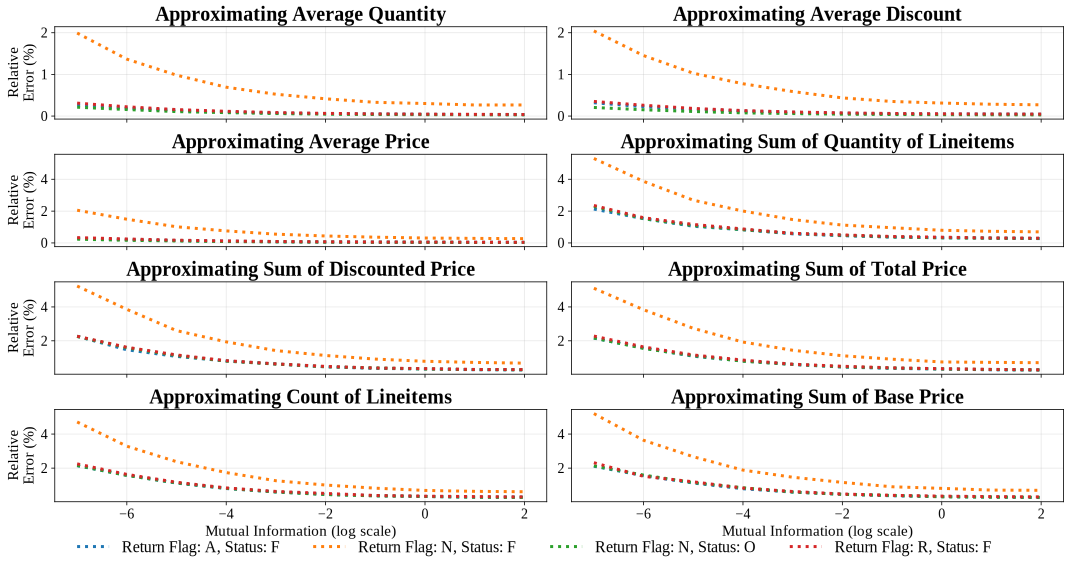

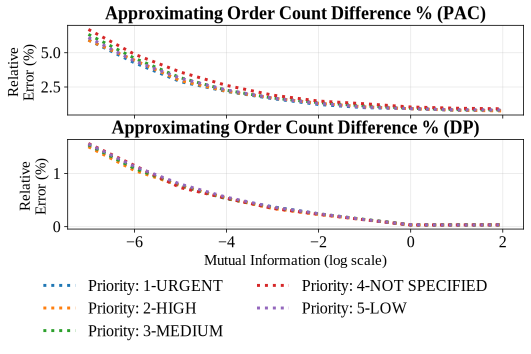

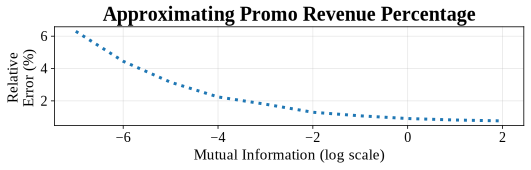

In [87]:
for query_ind in [1, 4, 14]:
    full_df = pl.DataFrame()
    for mi in [1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1.0, 2.0, 4.0]:
        null_info = {}
        orig = pl.read_csv(f'../unnoised/q{query_ind}.csv')
        if query_ind == 22:
            orig = orig.select(
            pl.col("cntrycode").cast(str),
            pl.col("numcust"),
            pl.col("totacctbal"))
        if query_ind == 10:
            orig = orig.select(
                pl.col("c_custkey"), pl.col("c_name"),
                pl.col("c_acctbal").cast(str),
                pl.col("n_name"), pl.col("c_address"), pl.col("c_phone"), pl.col("c_comment")
            )
        noised = pl.read_json(f'../outputs/ap-duckdb-q{query_ind}-customer-{mi}-step3/output.json')
        if index_cols[query_ind]:
            merged_df = orig.join(noised, on=index_cols[query_ind], how='left', suffix='_noised')
        else:
            merged_df = orig.join(noised, suffix='_noised', how='cross')
        suffix1 = ''
        suffix2 = '_noised'
        cols_with_suffixes = [col for col in merged_df.columns if suffix1 in col or suffix2 in col]

        base_names = set([col.replace(suffix1, '').replace(suffix2, '') for col in cols_with_suffixes])
        for base_name in base_names:
            nulls_exist = False
            null_inds, null_vals = [], []

            orig = base_name + suffix1
            noised = base_name + suffix2
            if orig in merged_df.columns and noised in merged_df.columns:
                rel_errors = []
                for ind in range(len(merged_df[orig])):
                    if query_ind in scale_required:
                        const = 2 # subsampling scaling
                        if query_ind == 1 and not (base_name[:3] == 'sum' or base_name[:5] == 'count'):
                            const = 1 # remove for parts of q1
                    else:
                        const = 1
    #                     print(merged_df[noised][ind])
                    noised_vals = [merged_df[noised][ind][tmp_ind] for tmp_ind in range(
                        len(merged_df[noised][ind])) if merged_df[noised][ind][tmp_ind] is not None]
#                     print(merged_df[noised])
                    new = np.average(
                        [100*abs(
                            const*noised_vals[tmp_ind] - merged_df[orig][ind]
                            ) / merged_df[orig][ind] for tmp_ind in range(
                                len(noised_vals))]
                    )
                    rel_errors.append(new)
                merged_df = merged_df.with_columns(pl.Series('pct_diff_' + base_name, rel_errors))
                merged_df = merged_df.with_columns(pl.Series('mi', [mi]*len(rel_errors)))
        full_df = pl.concat([full_df, merged_df])
    graph_query(full_df, query_ind)

In [88]:
merged_df

promo_revenue,promo_revenue_noised,pct_diff_promo_revenue,mi
f64,list[f64],f64,f64
16.380779,"[16.207844, 16.390401, … 16.368836]",0.759521,4.0


In [89]:
d1 = {1: 0.7823374160683711,
 4: 2.305804704221151,
 5: 8.511953848529734,
 6: 1.228637443673173,
 7: 8.477811977105551,
 8: 36.58862322359832,
 9: 7.132781250529975,
 12: 2.9258400322764784,
 13: 11.326969733512566,
 14: 2.2426424225685704,
 15: 34.752222455185645,
 17: 11.965279091428247,
 19: 26.98137762068436,
 21: 63.70192764773913,
 22: 7.541037928966193}

avg_errors_128 = {
    "Q2": 0.,
    "Q5": 8.511953848529734,
    "Q6": 1.228637443673173,
    "Q7": 8.477811977105551,
    "Q8": 36.58862322359832,
    "Q9":  7.132781250529975,
    "Q11": 0.,
    "Q12": 2.9258400322764784,
    "Q13": 11.326969733512566,
    "Q15": 34.752222455185645,
    "Q16": 0.,
    "Q17": 11.965279091428247,
    "Q19": 26.98137762068436,
    "Q21": 63.70192764773913,
    "Q22": 7.541037928966193}

d2 = {1: 0.785828208764725,
 4: 2.4677909757283887,
 5: 8.827659336676739,
 6: 1.2123002259492215,
 7: 8.617294680077064,
 8: 36.917711133712885,
 9: 7.176062565240494,
 12: 3.0246037673642157,
 13: 11.008566282146807,
 14: 2.228009736987251,
 15: 35.23429773261536,
 17: 11.412248196264983,
 19: 24.43835602807475,
 21: 63.772803851606845,
 22: 8.076624446828756}
# Q20
# [44.15913978494623, 44.25752688172042, 44.36720430107526, 44.26344086021504, 44.20483870967741, 44.21021505376343, 44.2268817204301, 44.27150537634408, 44.184408602150526, 44.231720430107515]
# [44.16935483870967, 44.198924731182785, 44.34193548387096, 44.29516129032257, 44.24569892473117, 44.17204301075268, 44.27956989247311, 44.2747311827957, 44.24784946236558, 44.29462365591397]
avg_errors = {'Q2': 0,
 'Q5': 8.827659336676739,
 'Q6': 1.2123002259492215,
 'Q7': 8.617294680077064,
 'Q8': 36.917711133712885,
 'Q9': 7.176062565240494,
 'Q11': 0,
 'Q12': 3.0246037673642157,
 'Q13': 11.008566282146807,
 'Q15': 35.23429773261536,
 'Q16': 0,
 'Q17': 11.412248196264983,
 'Q19': 24.43835602807475,
 'Q21': 63.772803851606845,
 'Q22': 8.076624446828756}

# {1: 0.0,
#  3: 100.0,
#  4: 0.0,
#  5: 0.0,
#  6: 0.0,
#  7: 0.0,
#  8: 0.0,
#  9: 0.0,
#  12: 0.0,
#  13: 11.904761904761905,
#  14: 0.0,
#  15: 0.0,
#  17: 0.0,
#  19: 0.0,
#  21: 12.0,
#  22: 0.0}
null_pct = {
    "Q3": 100,
    "Q13": 11.904761904761905,
    "Q10": 100,
    "Q18": 100,
    "Q21": 12.
}

# {1: 0.0,
#  3: 100.0,
#  4: 0.0,
#  5: 0.0,
#  6: 0.0,
#  7: 0.0,
#  8: 0.0,
#  9: 0.0,
#  12: 0.0,
#  13: 11.904761904761905,
#  14: 0.0,
#  15: 0.0,
#  17: 0.0,
#  19: 0.0,
#  21: 1.0,
#  22: 0.0}
# [46.239784946236554, 46.15913978494623, 46.01075268817203, 46.217741935483865, 46.3016129032258, 46.00913978494623, 46.280107526881714, 46.191935483870964, 46.159677419354836, 46.273118279569886]
# [46.31182795698924, 46.19408602150537, 46.3010752688172, 46.25752688172042, 46.22258064516129, 46.14677419354838, 46.21129032258064, 46.17688172043011, 46.195161290322574, 46.17204301075268]

null_pct_128 = {
    "Q3": 100,
    "Q13": 11.904761904761905,
    "Q10": 100,
    "Q18": 100,
    "Q21": 1.0
}

In [90]:
max_diff = 0.
max_key = None
for k in d1:
    assert k in d2
    if abs(d1[k] - d2[k]) > max_diff:
        max_diff = abs(d1[k] - d2[k])
        max_key = k
max_key, max_diff

(19, 2.543021592609609)

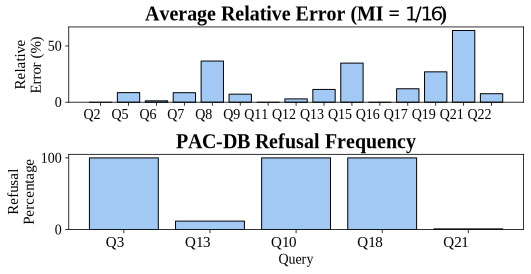

In [91]:
# Create the bar plot for unnoised times
import matplotlib as mpl
import matplotlib_inline.backend_inline

mpl.rcParams['savefig.dpi'] = 300

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.frameon'] = False


colors = ['#a1c9f4', '#8de5a1', '#ff9f9b', '#d0bbff', '#fffea3', '#b9f2f0']
cmap = mpl.colors.ListedColormap(colors)
bar1 = {'color': colors[0], 'edgecolor': 'k'}
bar2 = {'color': colors[1], 'edgecolor': 'k'}
bar3 = {'color': colors[2], 'edgecolor': 'k'}
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5, 4))

error_keys = avg_errors_128.keys()
error_vals = avg_errors_128.values()
ax1.bar(error_keys, error_vals, color=colors[0], edgecolor='k')
x = range(len(error_keys))
ax1.set_xticks(x, error_keys, ha='right', fontsize=14)
# ax1.set_xlabel('Query', fontsize=16)
ax1.set_ylabel('Relative\nError (%)', fontsize=15)
ax1.tick_params(axis='y', labelsize=14)  # Set y-tick font size to 14
ax1.set_title("Average Relative Error (MI = $1/16$)", fontsize=20)


error_keys = null_pct_128.keys()
error_vals = null_pct_128.values()
ax2.bar(error_keys, error_vals,color=colors[0], edgecolor='k')
x = range(len(error_keys))
ax2.set_xticks(x, error_keys, ha='right', fontsize=15)
ax2.set_xlabel('Query', fontsize=14)
ax2.set_ylabel('Refusal\nPercentage', fontsize=15)
ax2.tick_params(axis='y', labelsize=14)  # Set y-tick font size to 14
ax2.set_title("PAC-DB Refusal Frequency", fontsize=20)

plt.subplots_adjust(hspace=0.5)  # Add padding between plots
plt.tight_layout()
plt.savefig('../figs/overall_utility.png')

In [ ]:
g